<a href="https://colab.research.google.com/github/superahxd/_project/blob/main/sec4/dimensional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/au5gb676lynlzn2pm3rjgbp67d7ces')

In [3]:
df = df[['content','sentiment']]
text, sentiment = list(df['content']), list(df['sentiment'])

In [4]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import nltk

nltk.download('stopwords')

stopwordlist = stopwords.words('english')
stemmer = SnowballStemmer('english')
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer. 표제어 추출하기
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns. 정규식 패턴
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" 
    userPattern       = '@[^\s]+' #@으로 시작하는 유저 아이디 제거
    alphaPattern      = "[^a-zA-Z]" #영어 대소문자 외 제거
    sequencePattern   = r"(.)\1\1+" #중복글자 제거
    seqReplacePattern = r"\1\1" #중복글자제거
    
    for tweet in textdata:
        tweet = tweet.lower() #소문자화
        #http, www, https로 시작하는 url 제거
        tweet = re.sub(urlPattern,' URL',tweet)
        # 이모지 대체
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # 유저 아이디 대체
        tweet = re.sub(userPattern,' USER', tweet)        
        # 알파벳 아닌 것 모두 대체
        tweet = re.sub(alphaPattern, " ", tweet)
        # 3개 이상의 연속된 문자를 2자로 대체
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # stopword에 들어있는지 확인
            # stopword에 없으면:
            if len(word)>1:
                # Lemmatizing 실행
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [6]:
import time

nltk.download('wordnet')

t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Text Preprocessing complete.
Time Taken: 5 seconds


In [7]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [8]:
# worry, sadness, hate, empty, boredom, anger => negative
# happiness, love, surprise, fun, relef, enthusiasm => positive
df['sentiment'] = df['sentiment'].replace(['worry', 'sadness','hate','empty', 'boredom', 'anger'], 'n')
df['sentiment'] = df['sentiment'].replace(['happiness','love','surprise','fun','relief','enthusiasm'],'p')

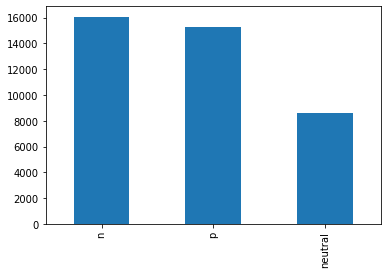

In [9]:
df['sentiment'].value_counts().plot(kind='bar')

token

In [10]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [11]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 32000
TEST size: 8000


In [12]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 22712


In [13]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (32000, 30)
Testing X Shape: (8000, 30)


labelencoder

In [14]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (32000, 1)
y_test shape: (8000, 1)


embedding

In [15]:
!wget http://nlp.stanford.edu/data/glove.6B.zip -N /content/glove.6B.zip
!unzip /content/glove.6B.zip

--2021-09-04 15:29:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-04 15:29:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-04 15:29:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [16]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../best_model.hdf5'

In [17]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [18]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [19]:
import tensorflow as tf
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [33]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Conv2D, MaxPooling1D, Flatten
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [35]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
#x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(64, 5)(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(13, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

ValueError: ignored

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [23]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
32/32 [==============================] - 48s 443ms/step - loss: 2.1962 - accuracy: 0.2310 - val_loss: 2.1094 - val_accuracy: 0.2791
Epoch 2/10
32/32 [==============================] - 13s 412ms/step - loss: 2.0430 - accuracy: 0.2955 - val_loss: 1.9996 - val_accuracy: 0.3181
Epoch 3/10
32/32 [==============================] - 13s 414ms/step - loss: 1.9794 - accuracy: 0.3192 - val_loss: 1.9477 - val_accuracy: 0.3351
Epoch 4/10
32/32 [==============================] - 13s 411ms/step - loss: 1.9443 - accuracy: 0.3341 - val_loss: 1.9384 - val_accuracy: 0.3365
Epoch 5/10
32/32 [==============================] - 13s 416ms/step - loss: 1.9193 - accuracy: 0.3447 - val_loss: 1.9149 - val_accuracy: 0.3466
Epoch 6/10
32/32 [==============================] - 13s 416ms/step - loss: 1.8953 - accuracy: 0.3522 - val_loss: 1.9103 - val_accuracy: 0.3399
Epoch 7/10
32/32 [==============================] - 13s 394ms/step - loss: 1.8687 - accuracy: 0.3598 - val_loss: 1.8993 - val_accuracy: 0.3520

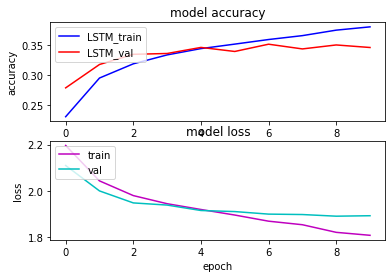

In [24]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [25]:
scores = model.predict(x_test, y_test)

ValueError: ignored

In [ ]:
n